In [1]:
%tensorflow_version 2.x
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import skimage

In [2]:
import tensorflow_datasets as tfds
merced_builder = tfds.builder('uc_merced')
# Download the dataset
merced_builder.download_and_prepare()

Shuffling and writing examples to /root/tensorflow_datasets/uc_merced/2.0.0.incompleteKWP7IS/uc_merced-train.tfrecord


Dataset uc_merced downloaded and prepared to /root/tensorflow_datasets/uc_merced/2.0.0. Subsequent calls will reuse this data.


In [3]:
print(merced_builder.info)


tfds.core.DatasetInfo(
    name='uc_merced',
    version=2.0.0,
    description='UC Merced is a 21 class land use remote sensing image dataset, with 100 images
per class. The images were manually extracted from large images from the USGS
National Map Urban Area Imagery collection for various urban areas around the
country. The pixel resolution of this public domain imagery is 0.3 m.

While most images are 256x256 pixels, there are 44 images with different shape.',
    homepage='http://weegee.vision.ucmerced.edu/datasets/landuse.html',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=21),
    }),
    total_num_examples=2100,
    splits={
        'train': 2100,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{Nilsback08,
       author = "Yang, Yi and Newsam, Shawn",
       title = "Bag-Of-Visual-Words

In [4]:
f = merced_builder.info.features['image']
print(f)
PATCH_WIDTH = 128
PATCH_HEIGHT = 128

Image(shape=(None, None, 3), dtype=tf.uint8)


The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


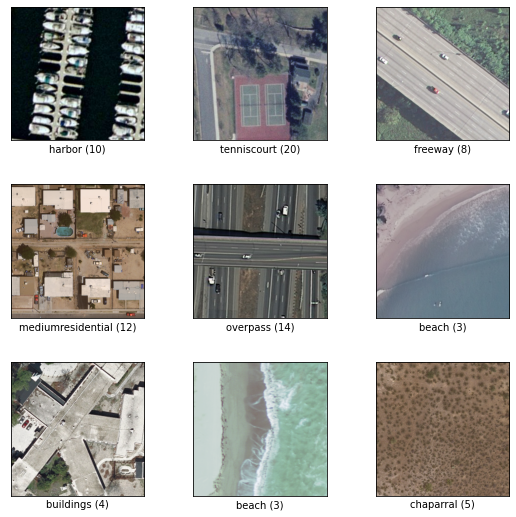

In [6]:
datasets = merced_builder.as_dataset()
full_ds = datasets['train']
fig = tfds.show_examples(merced_builder.info, full_ds)

In [9]:
# add gaussian noise to image
# note: this returns the noisy image as well as the original image
def add_noise(original, std_dev=0.1):
    noise = tf.random.normal(shape=tf.shape(original), mean=0.0, stddev=std_dev, dtype=tf.float32)
    noisy = tf.add(original, noise)
    noisy = tf.clip_by_value(noisy, 0.0, 1.0) # adding noise might make values > 1.0
    # return both the noisy and the normal image
    tensor_tuple = (noisy, original)
    return tensor_tuple

In [10]:
# extracts patches of given size from the image
def extract_patches(example, patch_width=PATCH_HEIGHT, patch_height=PATCH_HEIGHT):
  img = example['image']
  img = tf.image.convert_image_dtype(img, tf.float32)
  patches = tf.image.extract_patches([img], 
     sizes=[1, patch_height, patch_width, 1], 
     strides=[1, patch_height, patch_width, 1],
     rates=[1, 1, 1, 1],
     padding='SAME')
  img_tensor = tf.reshape(patches, [-1, patch_height, patch_width, 3])
  return tf.data.Dataset.from_tensor_slices(img_tensor)

In [ ]:
32*256*256*3 + 32

In [11]:
TRAIN_SIZE = int(2100*0.7)

train_ds = full_ds.take(TRAIN_SIZE)
test_ds = full_ds.skip(TRAIN_SIZE)

In [12]:
# prep dataset for training
train_ds = train_ds.flat_map(extract_patches)
train_ds = train_ds.map(add_noise)

In [13]:
# prep dataset for testing
# full-size patches in test data, want to test whole images
test_ds = test_ds.flat_map(lambda x: extract_patches(x, 256, 256))
test_ds = test_ds.map(add_noise)
test_ds = test_ds.batch(1) # one item per batch

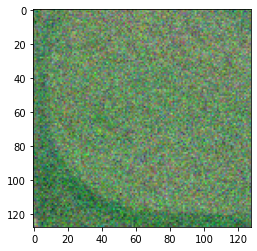

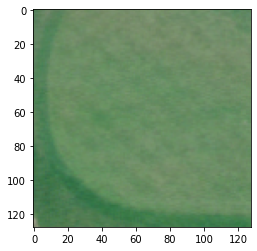

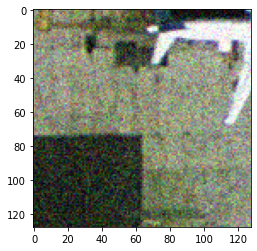

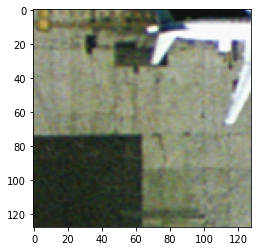

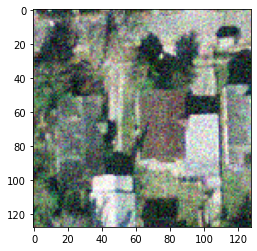

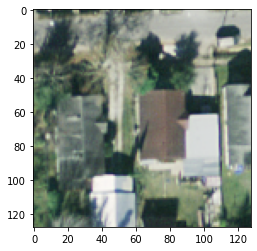

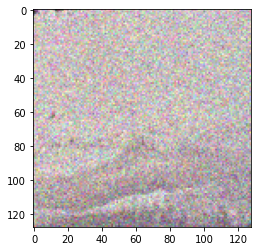

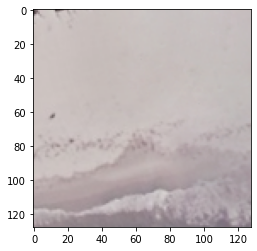

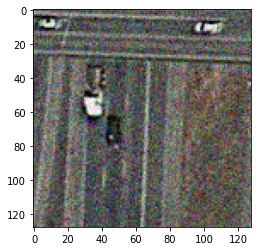

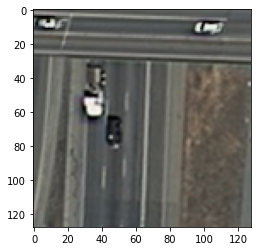

In [14]:
for noisy, orig in train_ds.shuffle(100).take(5): #shuffling before 'take' will give us different images each time
    plt.figure()
    plt.imshow(noisy)
    plt.figure()
    plt.imshow(orig)

In [15]:
# repeat, shuffle and batch
train_ds = train_ds.repeat().shuffle(1024).batch(32)
# prefetch to asynchronously fetch batches while the model is training
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [16]:
def create_modelCNN():
    # build a sequential CNN model
    model = tf.keras.models.Sequential([
        # a stack of Conv2D layers
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(None, None, 3)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',),
        tf.keras.layers.Conv2D(3, (3, 3), activation='relu', padding='same',),
    ])
    return model

In [17]:
def create_modelAE():
    # build a sequential AutoEncoder model (not used here: just for comparison of number of parameters)
    model = tf.keras.models.Sequential([
        # a stack of Conv2D layers
        tf.keras.layers.Dense(32, activation='relu', input_shape=(None, None, 3)),
        tf.keras.layers.Dense(128*128*3, activation='sigmoid'),
	      tf.keras.layers.Reshape((128, 128, 3))
	  ])
    return model

In [18]:
modelCNN = create_modelCNN()
print(modelCNN.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 32)    896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 3)     1731      
Total params: 21,123
Trainable params: 21,123
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
modelAE = create_modelAE()
print(modelAE.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, None, 32)    128       
_________________________________________________________________
dense_1 (Dense)              (None, None, None, 49152) 1622016   
_________________________________________________________________
reshape (Reshape)            (None, 128, 128, 3)       0         
Total params: 1,622,144
Trainable params: 1,622,144
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
model = modelCNN

In [21]:
# compile
model.compile(optimizer='adamax', loss='mae')

In [22]:
train_hist = model.fit(train_ds, epochs=10, steps_per_epoch=10)
                                 

Epoch 1/10
10/10 [==============================] - 36s 3s/step - loss: 0.1696
Epoch 2/10
10/10 [==============================] - 31s 3s/step - loss: 0.0774
Epoch 3/10
10/10 [==============================] - 31s 3s/step - loss: 0.0674
Epoch 4/10
10/10 [==============================] - 31s 3s/step - loss: 0.0596
Epoch 5/10
10/10 [==============================] - 32s 3s/step - loss: 0.0553
Epoch 6/10
10/10 [==============================] - 32s 3s/step - loss: 0.0497
Epoch 7/10
10/10 [==============================] - 31s 3s/step - loss: 0.0450
Epoch 8/10
10/10 [==============================] - 31s 3s/step - loss: 0.0423
Epoch 9/10
10/10 [==============================] - 31s 3s/step - loss: 0.0409
Epoch 10/10
10/10 [==============================] - 31s 3s/step - loss: 0.0389


In [23]:
NUM_PREDICT=3
prediction_batches = test_ds.take(NUM_PREDICT)

In [27]:
def show_results():
    # plot
    n = NUM_PREDICT  
    plt.figure(figsize=(15, 15))
    for i in range(n):
        # display noisy image
        ax = plt.subplot(4, n, i + 1)
        ax.set_title("Noisy")
        plt.imshow(noisy_imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 + n)
        ax.set_title("Denoised")
        plt.imshow(denoised_imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display ground truth
        ax = plt.subplot(4, n, i + 1 + n + n)
        ax.set_title("Ground Truth")
        plt.imshow(hires_imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display the difference (ssim)
        ax = plt.subplot(4, n, i + 1 + n + n + n)
        ax.set_title("Difference")
        plt.imshow(skimage.invert(skimage.util.compare_images(hires_imgs[i], denoised_imgs[i], method='diff')))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [25]:
hires_imgs = []
noisy_imgs = []
denoised_imgs = []
n=0
for nimg,himg in prediction_batches:
    # predict denoising from the noisy images
    pimg = model.predict(nimg)
    ssim = tf.image.ssim(tf.convert_to_tensor(np.expand_dims(pimg, 0)), himg, 1.0)
    print('SSIM: image:', n, ssim)
    # remove the extra batch dimension for matplotlib
    denoised_imgs.append(tf.squeeze(pimg))
    hires_imgs.append(tf.squeeze(himg))
    noisy_imgs.append(tf.squeeze(nimg))
    n += 1

SSIM: image: 0 tf.Tensor([[0.79011375]], shape=(1, 1), dtype=float32)
SSIM: image: 1 tf.Tensor([[0.7861643]], shape=(1, 1), dtype=float32)
SSIM: image: 2 tf.Tensor([[0.6315711]], shape=(1, 1), dtype=float32)


AttributeError: ignored

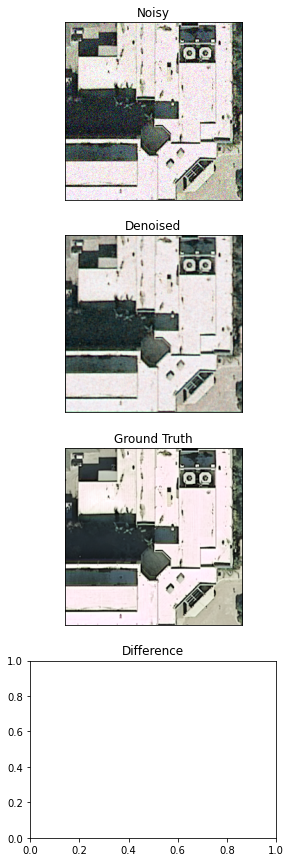

In [28]:
show_results()